In [87]:
import numpy as np
from os import path
import os
import pandas as pd
import sqlite3
from eventregistry import *
from datetime import date, timedelta, datetime
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
import string
import warnings
#import ConfigurationManager as cfg
import sys
from operator import itemgetter
from sklearn.model_selection import train_test_split
from sklearn import metrics
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    from keras.models import load_model
    from keras.preprocessing.text import Tokenizer
    from keras.preprocessing.sequence import pad_sequences
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, GlobalMaxPool1D
    from keras.layers import Flatten
    from keras.layers import Embedding
    from keras.callbacks import EarlyStopping,CSVLogger
    import tensorflow as tf
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#print('CONFIG VALUE :' + cfg.read_config('sql_db_path'))

model_path = 'C:\\Users\\HIMS\\Downloads\\DueDilWorkspace\\DueDiligenceUI\\Models\\'
#sql_db_path = cfg.read_config('sql_db_path')
max_length = 1584
embedding_dim = 50
sentence_buffer = 3
X_train=[]
X_test=[]
y_train=[]
y_test=[]
y_pred =[]
y_proba=[]

def fetch_data_db():
    conn = sqlite3.connect(sql_db_path)
    c = conn.cursor()
    myquery = ("SELECT Id,ArticleText,Outcome FROM DueDiligenceUI_trainingmodel WHERE IsTrained=1 and Outcome IS NOT NULL")
    c.execute(myquery)
    result = c.fetchall()
    X = []
    Y = []
    Ids = []
    for record in result:
        Ids.append(str(record[0]))
        X.append(record[1])
        Y.append(record[2])
    #print("UPDATE DueDiligenceUI_trainingmodel SET IsTrained=1 WHERE Id IN (" + ','.join(Ids) + ")")
    myquery = ("UPDATE DueDiligenceUI_trainingmodel SET IsTrained=1 WHERE Id IN (" + ','.join(Ids) + ")")
    c.execute(myquery)
    conn.commit()
    c.close()
    conn.close()

    return X, Y, False

def fetch_data_CSV():
    training_data = pd.read_csv(model_path + 'TrainingData.csv', encoding='latin1')
    training_data = training_data.drop('Name', axis=1)

    # conn = sqlite3.connect(sql_db_path)
    # c = conn.cursor()
    # cursorObj = conn.cursor()
    #
    # for ind in training_data.index:
    #     content = training_data["Data"][ind]
    #     outcome = training_data["Pattern"][ind]
    #     articleDateTime = datetime.today()
    #     # Insert article into database
    #     sql = "INSERT INTO DueDiligenceUI_trainingmodel (ArticleText, Outcome, TrainingDate, SearchModel_id, IsTrained) " \
    #           "VALUES(?,'" + str(outcome) + "','" + str(articleDateTime) + "',0,1) "
    #     #print(sql)
    #     cursorObj.execute(sql, [content])
    #     conn.commit()
    #
    # cursorObj.close()
    # conn.close()
    
    return training_data['Data'], training_data['Pattern'].values, True

    # turn a doc into clean tokens

def clean_article(article_content):
    tokens = [word.replace('\\n', ' ').replace('\n', ' ').replace('  ', ' ') for word in article_content.split()]
    #print(tokens)
    # split again in order to accomodate replaced spaces into tokens by white space
    article_content = " ".join(tokens)
    tokens = article_content.split()
    #print(tokens)
    # remove punctuation from each token except Full Stop(.)
    table = str.maketrans('', '', '!"#$%&\'()*+,/:;<=>?@[\\]^_`{|}~')
    tokens = [w.translate(table) for w in tokens]
    #print(tokens)
    # remove remaining tokens that are not alphabetic
    tokens = [word.strip() for word in tokens if word.strip().isalpha() or '.' in word or '-' in word]
    #print(tokens)
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    #print(tokens)
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1 or '.' in word or '-' in word]
    #print(tokens)
    return tokens

def unique_list(list):
    uniquelist = []
    [uniquelist.append(word) for word in list if word not in uniquelist or word == 'ENTITY']
    return uniquelist

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

def fetch_data_eventregistry(entityname):
    er = EventRegistry(apiKey="f4a005ab-a24f-487e-bff4-f39b1b2ba6c2")
    # q = QueryArticlesIter(
    #     keywords=entityname,
    #     dataType=["news"],  # , "blog"],
    #     lang="eng",
    #     dateStart=date.today() - timedelta(days=30),
    #     dateEnd=date.today())
    cq = ComplexArticleQuery(
        query=CombinedQuery.AND(
            [
                BaseQuery(keyword=QueryItems.AND(["narendra", "modi"]),
                          #sourceLocationUri=er.getLocationUri("United States"),
                          lang="eng",
                          dateStart=date.today() - timedelta(days=45),
                          dateEnd=date.today()
                          ),
                BaseQuery(keyword=QueryItems.OR(
                    ["sanction", "bribery", "laundering", "corruption", "blacklist", "crime", "scam", "fraud"]))
                # "drugs","trafficking","gambling","illegal","smuggling","terrorism",
                # "extortion","forgery","tax evasion","SDN","burglary","robbery","murder"]))
            ])
    )
    q = QueryArticles.initWithComplexQuery(cq)
    q.setRequestedResult(RequestArticlesInfo(page=1,
                                             count=10,
                                             sortBy="date", sortByAsc=False,
                                             returnInfo=ReturnInfo()))
    res = er.execQuery(q)

    X = []

    conn = sqlite3.connect(sql_db_path)
    c = conn.cursor()
    cursorObj = conn.cursor()
    # obtain at most 500 newest articles or blog posts
    for article in res['articles']['results']:
        content = article["body"]
        articleDateTime = article["dateTime"].replace('T', ' ', 1).replace('Z', '', 1)
        # Insert article into database
        sql = "INSERT INTO DueDiligenceUI_trainingmodel (ArticleText, TrainingDate, SearchModel_id, IsTrained) " \
              "VALUES(?,'" + articleDateTime + "',0,0) "
        print(sql)
        cursorObj.execute(sql, [content])
        conn.commit()
        # print('---------------------------------Article Body---------------------------------')
        # print(content + os.linesep)
        # printn('---------------------------------Tokens---------------------------------')
        #tokens = unique_list(clean_article(content))
        tokens = clean_article(content)
        token_sentence = " ".join(tokens)
        # print(token_sentence)
        X.append(token_sentence)
    cursorObj.close()
    conn.close()
    return X

def train_sequential_model(X, Y, is_split_data):
    print('Number of records for training the model : ', str(len(X)))
    # Data pre-processing
    for index, value in enumerate(X):
        #print(value)
        #tokens = unique_list(clean_article(value))
        tokens = clean_article(value)
        #print('\n-------------------------------------------\n')
        # Slice out max length characters from the article
        # if len(tokens) > max_length:
        #     tokens = tokens[:max_length]

        cleaned_article = " ".join(tokens)
        #print(cleaned_article)
        # Grab Before and After 2 sentences of sentence with ENTITY word
        sentences = sent_tokenize(cleaned_article)
        indices = [idx for idx, sent in enumerate(sentences) if 'ENTITY' in sent]
        #print(indices)
        extended_indices = []
        for i, sentence in enumerate(sentences):
            extended_indices.extend(list(set([i for index in indices if abs(index-i) <= sentence_buffer])))
        #print(extended_indices)
        #print(len(sentences))
        #print(cleaned_article)
        desired_list = list(itemgetter(*extended_indices)(sentences))

        #print(" ".join(desired_list))

        X[index] = " ".join(desired_list)
        #print('\n++++++++++++++++++++++++++++++++++++++++++++++\n')
        #print(X[index].encode('utf-8'))
        #print('\n++++++++++++++++++++++++++++++++++++++++++++++\n')

    # prepare tokenizer
    t = Tokenizer()
    t.fit_on_texts(X)
    vocab_size = len(t.word_index) + 1
    print('vocab_size : ' + str(vocab_size))

    if path.exists(model_path + 'trained_model.h5'):
        #model = load_model(model_path + 'trained_model.h5')
        os.remove(model_path + 'trained_model.h5')

        # max_length = int(cfg.read_config('max_length'))
        #
        # for index, value in enumerate(X):
        #     tokens = unique_list(clean_article(value))
        #     # Slice out max length characters from the article
        #     if len(tokens) > max_length:
        #         tokens = tokens[:max_length]
        #     X[index] = " ".join(tokens)
    #else:
    # pad documents to a max length of words
    max_length = max([len(sentence.split()) for sentence in X])
    print('max_length : ' + str(max_length))
    # Write Max length to config file
    #cfg.write_config('max_length', str(max_length))

    # load the whole embedding into memory
    embedding_matrix = create_embedding_matrix(model_path + 'glove.6B.50d.txt', t.word_index, embedding_dim)

    # define model
    model = Sequential()
    e = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False)
    model.add(e)
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(GlobalMaxPool1D())    
    #model.add(Dropout(0.2))
    #model.add(Flatten())
    #model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    # integer encode the documents
    encoded_docs = t.texts_to_sequences(X)
    #print(encoded_docs)

    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
    #print(padded_docs)

    # summarize the model
    print(model.summary())
    
    global X_train
    global X_test
    global y_train
    global y_test
    global y_pred
    global y_proba
    
    X_train,X_test,y_train,y_test = train_test_split(padded_docs,Y, random_state=0)
    #if is_split_data:
    # fit the model
    #X_train = padded_docs[:len(padded_docs)-100]
    #y_train = Y[:len(padded_docs) - 100]
    print('X_train, y_train', str(len(X_train)), str(len(y_train)))
    #X_test = padded_docs[-100:]
    #y_test = Y[-100:]
    print('X_test, y_test', str(len(X_test)), str(len(y_test)))
   
    # X_val=X_train[-50:]
    # y_val=y_train[-50:]
    # print('X_val, y_val', str(len(X_val)), str(len(y_val)))

    es_callback = EarlyStopping(monitor='val_acc', patience=3)
    logger_callback = CSVLogger('training.log', separator=',', append=True)
    model.fit(X_train, y_train, batch_size=10, epochs=20, validation_data=(X_test, y_test), shuffle=True, verbose=1, callbacks=[logger_callback, es_callback])
    #, validation_freq=5,
    #, validation_split = 0.2

    # evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    # else:
    #     model.fit(padded_docs, Y, epochs=30, shuffle=True, verbose=1)
    #     loss, accuracy = model.evaluate(padded_docs, Y, verbose=1)
    
    y_pred = model.predict_classes(x=X_test, batch_size=5, verbose=2)        
    y_proba = model.predict(x=X_test, batch_size=5, verbose=2)
    
    print('Accuracy: %f' % (accuracy * 100))
    print('Loss: ', loss)

    # Save the model to disk
    model.save(model_path + 'trained_model.h5')
    print("Model saved to disk.")
    
print('#######################################################################################')
print('Select an operation : ')
print('1. Train the Model')
print('2. Feedback to the Model')
print('#######################################################################################')
inp = input('Enter the number : ')
if inp == '1':
    X, Y, is_split_data = fetch_data_CSV()
elif inp == '2':
    X, Y, is_split_data = fetch_data_db()
else:
    print('Please select a valid option')
    sys.exit()

train_sequential_model(X,Y, is_split_data)

#######################################################################################
Select an operation : 
1. Train the Model
2. Feedback to the Model
#######################################################################################
Enter the number : 1
Number of records for training the model :  502
vocab_size : 13577
max_length : 1584
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 1584, 50)          678850    
_________________________________________________________________
dense_37 (Dense)             (None, 1584, 50)          2550      
_________________________________________________________________
dropout_19 (Dropout)         (None, 1584, 50)          0         
_________________________________________________________________
dense_38 (Dense)             (None, 1584, 50)          2550      
__________________________________

376/376 [==============================] - ETA: 1s - loss: 0.2273 - acc: 0.900 - ETA: 1s - loss: 0.3005 - acc: 0.866 - ETA: 1s - loss: 0.3704 - acc: 0.820 - ETA: 1s - loss: 0.3435 - acc: 0.857 - ETA: 1s - loss: 0.3486 - acc: 0.844 - ETA: 1s - loss: 0.3868 - acc: 0.818 - ETA: 0s - loss: 0.3801 - acc: 0.830 - ETA: 0s - loss: 0.3795 - acc: 0.833 - ETA: 0s - loss: 0.3804 - acc: 0.835 - ETA: 0s - loss: 0.3828 - acc: 0.831 - ETA: 0s - loss: 0.3815 - acc: 0.833 - ETA: 0s - loss: 0.3826 - acc: 0.834 - ETA: 0s - loss: 0.3884 - acc: 0.832 - ETA: 0s - loss: 0.3969 - acc: 0.822 - ETA: 0s - loss: 0.3948 - acc: 0.831 - ETA: 0s - loss: 0.3885 - acc: 0.838 - ETA: 0s - loss: 0.3842 - acc: 0.839 - ETA: 0s - loss: 0.3839 - acc: 0.842 - ETA: 0s - loss: 0.3777 - acc: 0.843 - 1s 4ms/step - loss: 0.3745 - acc: 0.8457 - val_loss: 0.3716 - val_acc: 0.8333
Epoch 9/20
376/376 [==============================] - ETA: 1s - loss: 0.4594 - acc: 0.800 - ETA: 1s - loss: 0.4806 - acc: 0.800 - ETA: 1s - loss: 0.4249 - ac

In [88]:
print('sklearn accuracy :', metrics.accuracy_score(y_test, y_pred))

sklearn accuracy : 0.873015873015873


In [89]:
max(y_test.mean(), 1-y_test.mean())

0.5158730158730158

In [91]:
print(y_test.shape)
print(y_pred.shape)
print('True:', y_test[0:30])
print('Pred:', y_pred[0:30].flatten())

(126,)
(126, 1)
True: [1 0 1 0 0 1 0 1 0 0 1 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0 1 1 0 1]
Pred: [1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0 1 1 0 0 1 1 0 1]


In [92]:
print(metrics.confusion_matrix(y_test, y_pred))

[[56  9]
 [ 7 54]]


In [74]:
print(metrics.recall_score(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred))

0.7954545454545454
0.8333333333333334


In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

Text(0, 0.5, 'Frequency of probability')

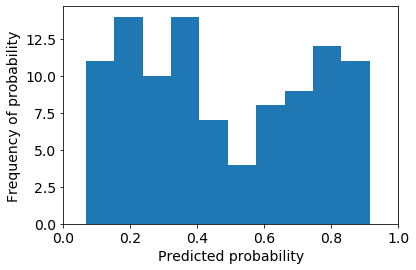

In [76]:
#print(y_proba[0:10])
plt.hist(y_proba, bins=10)
plt.xlim(0,1)
plt.xlabel('Predicted probability')
plt.ylabel('Frequency of probability')

In [63]:
from sklearn.preprocessing import binarize
y_pred_classes = binarize(y_proba, 0.6)
print(y_pred_classes[0][0])

1.0


In [64]:
print(y_test.shape)
print(y_pred_classes.shape)
print(metrics.confusion_matrix(y_test, y_pred_classes))

(100,)
(100, 1)
[[52  4]
 [10 34]]


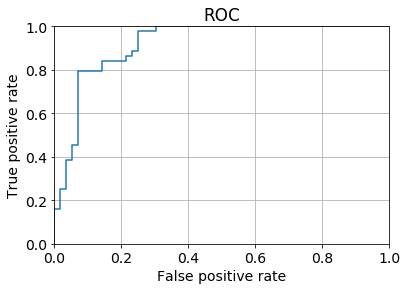

In [77]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('ROC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.grid(True)

In [78]:

# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [83]:
evaluate_threshold(0.4)

Sensitivity: 0.8863636363636364
Specificity: 0.7678571428571428


###### IMPORTANT: first argument is true values, second argument is predicted probabilities
print(metrics.roc_auc_score(y_test, y_proba))

In [84]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86        56
           1       0.83      0.80      0.81        44

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



In [112]:
arr = [[0.18996625],
 [0.18996625],
 [0.5760623 ],
 [0.6663987 ],
 [0.47609997],
 [0.6663987 ],
 [0.6663987 ],
 [0.6663987 ],
 [0.8477958 ],
 [0.8477958 ]]
test = [[0],
 [0],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1]]


In [117]:
pred = binarize(arr, 0.6)
pred

array([[0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [1]:
from difflib import SequenceMatcher
s_1 = 
s_2 = 'Mohan Mehte'
print(SequenceMatcher(a=s_1,b=s_2).ratio())

0.9090909090909091


In [50]:
from eventregistry import *
from datetime import date, timedelta
er = EventRegistry(apiKey="f4a005ab-a24f-487e-bff4-f39b1b2ba6c2")
cq = ComplexArticleQuery(
    query=CombinedQuery.AND(
        [
            BaseQuery(keyword=QueryItems.OR(['marsh & McLennan']),
                      #sourceLocationUri=er.getLocationUri("United States"),
                      lang="eng",
                      dateStart=date.today() - timedelta(days=365),
                      dateEnd=date.today()
                      ),
            BaseQuery(keyword=QueryItems.OR(
               ["sanction", "bribery", "laundering", "corruption", "blacklist", "crime", "scam", "fraud"]))
            # "drugs","trafficking","gambling","illegal","smuggling","terrorism",
            # "extortion","forgery","tax evasion","SDN","burglary","robbery","murder"]))
        ])
)
q = QueryArticles.initWithComplexQuery(cq)
q.setRequestedResult(RequestArticlesInfo(page=1,
                                         count=10,
                                         sortBy="date", sortByAsc=False,
                                         returnInfo=ReturnInfo()))
res = er.execQuery(q)
for article in res['articles']['results']:
    print(article['body'].encode('utf-8'))
    print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')

using user provided API key for making requests
Event Registry host: http://eventregistry.org
Text analytics host: http://analytics.eventregistry.org
b'-- Anti-Corruption News Story Curated by Anti-Corruption Digest International Risk & Compliance News\n\nIn terms of the 10 most critical threats to doing business in the US and Canada, cyberattacks and data fraud or theft are the two biggest, a survey found.\n\nAnd on a global level, cyberattacks hold the No. 2 spot after fiscal crises, according to the study, produced by the World Economic Forum (WEF) in partnership with Marsh & McLennan and Zurich.\n\nIn Latin America, other risks top the table - largely related to governance and social instability - but awareness of the threat posed by cybercriminals is growing.\n\nInsurer Chubb has witnessed an increase in enquiries in the region, not just from within the financial services sector - which experienced several high-profile incidents over the past few years - but increasingly from othe

b'Vancouver, WA -- (SBWIRE) -- 11/15/2019 -- Growth in the Cyber insurance market\n\nCyber risks are becoming more prevalent and disruptive, with an increased number of incidents involving data breaches, phishing scams, malware attacks, ransomware threats, and identity theft. Cyber insurance helps protect businesses against losses resulting from cyber-attacks or data breaches. Cyber insurance coverage can include data loss and restoration, extortion, legal fees, and more. Cyber Security Insurance Market insurance increases and improves cyber security with the benefits of good security, and internalizing of the costs of poor security. There are many benefits that coincide with investing in insurance.\n\nAccess of PDF Sample @ https://www.blueweaveconsulting.com/cyber-security-insurances#ReportSample/\n\nThe growth of the US cyber insurance market is due to the introduction of legislation in most states to take appropriate security measures to protect against cyber risks and report serio

b'Is Calgary really the fifth most livable city the world?\n\nOnce again Calgary was ranked in the top 10 places (fifth place to be exact) in the world to live by The Economist, a weekly magazine of news and opinion published in London, UK, and regarded as one of the world\'s preeminent journals of its kind (Encyclopaedia Britannica). And Calgary has been in the top 10 for as long as I can remember.\n\nWhile some Calgarians herald this as evidence Calgary is doing OK, others gave their heads a shake and ask "how can Calgary be a better place to live than Paris, Barcelona, Copenhagen or any one of a number of dynamic cities around the world?" On social media, several Calgarians noted Calgary\'s high unemployment rate and high taxes for small businesses as evidence Calgary is no longer a great place to live. Yet others see it as simply click-bait.\n\nGrain of salt\n\nAs with any benchmarking, the ranking depends on what you measure. In the case of The Economist, 30 parameters are divided

In [23]:
from difflib import SequenceMatcher
s_1 = res['articles']['results'][6]['body']
s_2 = res['articles']['results'][9]['body']
print(SequenceMatcher(a=s_1,b=s_2).ratio())

0.894209161624892


In [25]:
# importing the model en_core_web_sm of English for vocabluary, syntax & entities
import en_core_web_sm

# load en_core_web_sm of English for vocabluary, syntax & entities
nlp = en_core_web_sm.load()

#  "nlp" Objectis used to create documents with linguistic annotations.
docs = nlp(u"Al Arabiyas correspondent reported members Lebanese army attempted urge car owners remove cars. According Hezbollah-affiliated ENTITY protesters closed municipality buildings Tripoli el-Mina well water authority north Lebanon. Meanwhile Association Banks Lebanon announced closure banks Monday protests continue across country.")

for word in docs:
    print(word.text,word.pos_)

Al PROPN
Arabiyas PROPN
correspondent NOUN
reported VERB
members NOUN
Lebanese ADJ
army NOUN
attempted VERB
urge NOUN
car NOUN
owners NOUN
remove VERB
cars NOUN
. PUNCT
According VERB
Hezbollah PROPN
- PUNCT
affiliated VERB
ENTITY PROPN
protesters NOUN
closed VERB
municipality NOUN
buildings NOUN
Tripoli PROPN
el PROPN
- PUNCT
Mina PROPN
well ADV
water NOUN
authority NOUN
north NOUN
Lebanon PROPN
. PUNCT
Meanwhile ADV
Association PROPN
Banks PROPN
Lebanon PROPN
announced VERB
closure NOUN
banks NOUN
Monday PROPN
protests NOUN
continue VERB
across ADP
country NOUN
. PUNCT
